# Milestone 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

We start by loading the tables.

In [2]:
df_plot = pd.read_csv("data/MovieSummaries/plot_summaries.txt", sep='\t', header=None, names=["wikiID", "plot"])

df_meta = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, 
    names=["wikiID", "freeID", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"])

df_char = pd.read_csv("data/MovieSummaries/character.metadata.tsv", sep='\t',header=None, 
    names=["WikiID", "freeID", "release_date", "char_name", "actor_DOB", "actor_gender", "actor_height", "actor_ethnicity",
           "actor_name", "Actor_age", "freeID_char_map", "FreeID_char", "FreeID_actor"])

df_char_names = pd.read_csv('data/MovieSummaries/name.clusters.txt', sep="\t", header=None, 
    names=["char_name", "freeID_char_map"])

df_tropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=["trope", "details"])

## Data features and missing values

In [3]:
df_plot.head()

,wikiID,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [4]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wikiID  42303 non-null  int64 
 1   plot    42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [5]:
df_meta.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikiID        81741 non-null  int64  
 1   freeID        81741 non-null  object 
 2   name          81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   revenue       8401 non-null   float64
 5   runtime       61291 non-null  float64
 6   languages     81741 non-null  object 
 7   countries     81741 non-null  object 
 8   genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Looking at the output above, we might think that the languages, countries and genres columns have no missing elements but actually some elements are just empty dictionary values

In [7]:
print(df_meta['languages'].value_counts()['{}'])
print(df_meta['countries'].value_counts()['{}'])
print(df_meta['genres'].value_counts()['{}'])

13866
8154
2294


Also, if we want to make use of the release date we can already convert it to datetime and check if we have more missing values.

In [8]:
df_meta['release_date'] = pd.to_datetime(df_meta['release_date'], errors = 'coerce')
print(df_meta['release_date'].shape[0] - df_meta['release_date'].isnull().sum())

74838


In [9]:
df_char.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [10]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WikiID           450669 non-null  int64  
 1   freeID           450669 non-null  object 
 2   release_date     440674 non-null  object 
 3   char_name        192794 non-null  object 
 4   actor_DOB        344524 non-null  object 
 5   actor_gender     405060 non-null  object 
 6   actor_height     154824 non-null  float64
 7   actor_ethnicity  106058 non-null  object 
 8   actor_name       449441 non-null  object 
 9   Actor_age        292556 non-null  float64
 10  freeID_char_map  450669 non-null  object 
 11  FreeID_char      192804 non-null  object 
 12  FreeID_actor     449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


In [11]:
df_char_names.head()

,char_name,freeID_char_map
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [12]:
df_char_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   char_name        2666 non-null   object
 1   freeID_char_map  2666 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


In [13]:
df_tropes.head()

,trope,details
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [14]:
df_tropes = df_tropes.drop(["details"], axis=1).join(pd.json_normalize(df_tropes["details"].map(json.loads).tolist())).rename(
    columns={"id":"freeID_char_map"})

df_tropes.head()

,trope,char,movie,freeID_char_map,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [15]:
df_tropes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   trope            501 non-null    object
 1   char             501 non-null    object
 2   movie            501 non-null    object
 3   freeID_char_map  501 non-null    object
 4   actor            501 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


---
## NLPCore

After we looked at the Stanford CoreNLP-processed summaries, we assumed it would not be useful for us.

The code below is an example where we load and parse the data to retrieve an element.

In [16]:
import gzip
import os
from bs4 import BeautifulSoup

path = "data/corenlp_plot_summaries/"
files = os.listdir(path)
print(files[0])
f = gzip.open(path+files[0], 'rb')

test = f.read().decode()
# print(test)

Bs_data = BeautifulSoup(test, "xml")
print(Bs_data.find("sentence", {'id':'20'}).find('NER').text)

10000053.xml.gz
O


---
## Exploratory data analysis

### Genres, languages and countries

We want to identify the most represented genres, languages and countries.

In [17]:
def fcount(df):
    df2 = pd.DataFrame(data={
        'id': df.apply(lambda x: list(json.loads(x).keys())),
        'name': df.apply(lambda x: list(json.loads(x).values()))
    })
    
    distinctf = []
    counter = []

    for i in range(df2.shape[0]):
        fid = df2["id"].iloc[i]
        fname = df2["name"].iloc[i]
        for j in range(len(fid)):
            if [fid[j], fname[j]] not in distinctf:
                distinctf.append([fid[j], fname[j]])
                counter.append(1)
            else:
                counter[distinctf.index([fid[j], fname[j]])] += 1

    new = pd.DataFrame(data={
        'id': [s[0] for s in distinctf],
        'name': [s[1] for s in distinctf],
        'count': counter
    })
    
    return new.sort_values(by="count", ascending=False, ignore_index=True)

In [18]:
df_genre = fcount(df_meta["genres"])
df_genre.head(20)

,id,name,count
0,/m/07s9rl0,Drama,34007
1,/m/01z4y,Comedy,16349
2,/m/02l7c8,Romance Film,10234
3,/m/01g6gs,Black-and-white,9094
4,/m/02kdv5l,Action,8798
5,/m/01jfsb,Thriller,8744
6,/m/02hmvc,Short Film,8141
7,/m/03q4nz,World cinema,7155
8,/m/0lsxr,Crime Fiction,6948
9,/m/0219x_,Indie,6897


In [19]:
df_lang = fcount(df_meta["languages"])
df_lang.head(20)

,id,name,count
0,/m/02h40lc,English Language,40891
1,/m/03k50,Hindi Language,3744
2,/m/06nm1,Spanish Language,3673
3,/m/064_8sq,French Language,3422
4,/m/06ppq,Silent film,3183
5,/m/02bjrlw,Italian Language,2531
6,/m/03_9r,Japanese Language,2295
7,/m/04306rv,German Language,2258
8,/m/07c9s,Tamil Language,1896
9,/m/0999q,Malayalam Language,1448


In [20]:
df_country = fcount(df_meta["countries"])
df_country.head(20)

,id,name,count
0,/m/09c7w0,United States of America,34408
1,/m/03rk0,India,8411
2,/m/07ssc,United Kingdom,7868
3,/m/0f8l9c,France,4395
4,/m/03rjj,Italy,3163
5,/m/03_3d,Japan,2647
6,/m/0d060g,Canada,2534
7,/m/0345h,Germany,2393
8,/m/0jgd,Argentina,1468
9,/m/03h64,Hong Kong,1240


There might be a correlation between the country and language features.

### Release date distribution

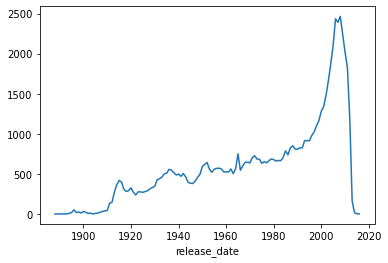

In [21]:
df_meta.groupby(df_meta["release_date"].dt.year).count()['wikiID'].plot()
plt.show()

We want to study the similarity between two movies so the date of their releases can be interesting. In this case, the exact release date might not be necessary, because it is expected that the difference would lie between movies that have for example 10 years of difference not just a few months. Actually, in some cases we only have the year of the release, so it might be simpler to only store the year of the release for all movies in order to keep homogeneous data.

### Runtime distribution

In [22]:
print(df_meta['runtime'].max())

1079281.0


2 years of runtime?

In [23]:
print(df_meta[df_meta['runtime'] >= 400].shape[0])
print(df_meta[df_meta['runtime'] <= 3].shape[0])

66
250


More than 6 hours of runtime seems too large and less than 3 minutes seems too short.

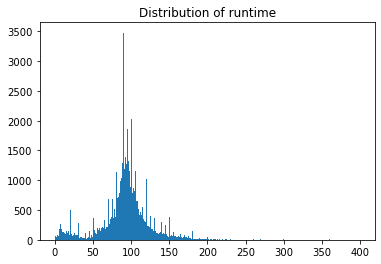

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_meta[df_meta['runtime'] < 400]['runtime'], bins=400)
ax.set_title('Distribution of runtime')

plt.show()

We can observe that the distribution is more concentrated around a runtime of 90 minutes but it appears there is a cluster around 20 which might corresponds to short films (6th most represented movie genre in the dataset).

The exact value of the runtime does not always seem to be reliable data, and looking at the distribution it might be a good idea to replace the runtime by an attribute like "short", "long" or "don't know" (if runtime is NaN).

### Runtime distribution

<AxesSubplot:>

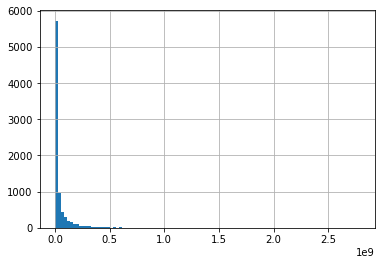

In [25]:
df_meta['revenue'].dropna().hist(bins=100)

In [26]:
print(df_meta['revenue'].max())

2782275172.0


In [27]:
print(df_meta[df_meta['revenue']==df_meta['revenue'].max()].name)

23702    Avatar
Name: name, dtype: object


There is a very large different between most of the movies and the movies that had a huge success such as "Avatar".

Note that the box office revenue is absent for most of the movies and we might not need it to compute the similarity between two movies. Therefore, we estimated that this feature would not be useful for our project.

### Distribution of the number of words per plot

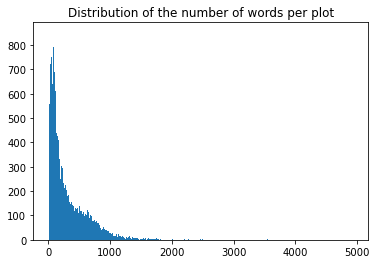

In [28]:
#use raw plot_summaries and count nb of words in each plot 
df_plot_fltr = df_plot.copy()
df_plot_fltr['nb_words'] = df_plot_fltr['plot'].apply(lambda n: len(n.split()))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Distribution of the number of words per plot')

plt.show()

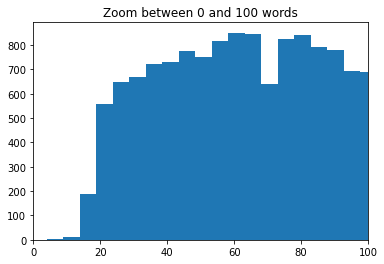

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Zoom between 0 and 100 words')
plt.xlim([0, 100])

plt.show()

We still find some extreme values in the distribution. In particular, some plots have less than 20 words, on the other hand there are plots with thousands of words.

In the preprocessing, we decided to discard the movies with plots that are less than 10 words as they might not be relevant when we will apply topic extraction.

### Distribution of the number of characters per movie

First we will group all the characters by movie. So if a movie has at least one labeled character, we will be able to count its number of character so that we can have an insight on the distribution of the number of characters for a movie.

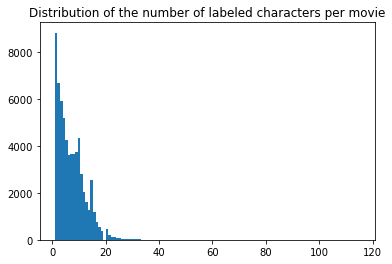

In [30]:
df_char_fltr = df_char[['freeID','FreeID_actor']].copy()
df_char_fltr = df_char_fltr.groupby(['freeID']).size()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_char_fltr, bins=120)
ax.set_title('Distribution of the number of labeled characters per movie')

plt.show()

In [31]:
print("Number of movies without any labeled character: ", 
      df_meta.shape[0] - df_meta[df_meta['freeID'].isin(df_char_fltr.index)].shape[0])

Number of movies without any labeled character:  17411


This can be missing information but it is also logical that some movies such as documentaries do not have any character.

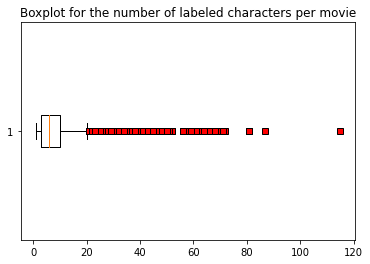

In [32]:
red_square = dict(markerfacecolor='r', marker='s')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(df_char_fltr, vert=False, flierprops=red_square)
ax.set_title('Boxplot for the number of labeled characters per movie')
plt.show()

In [33]:
print("1rst quartile, median and 3rd quartile values: ")
print(df_char_fltr.quantile([0.25,0.5,0.75]))

1rst quartile, median and 3rd quartile values: 
0.25     3.0
0.50     6.0
0.75    10.0
dtype: float64


## Join the dataframes

The feature connecting dataframes together is the Wikipedia ID. Also there are more metadatas of movies (81741 movies) than plots (42303 movies). We will only keep the metadatas of the movies we know the plot of.

In [34]:
df_full = df_meta.merge(df_plot, how='inner', on="wikiID")
df_full.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."


Only a small fraction of the characters have been labellised with a trope (500), compared to the number of unlabeled (450669). Here is the dataframe containing the characters with trope

In [35]:
df_char_trope = df_char.merge(df_tropes, how='inner', on='freeID_char_map')

df_char_trope.drop(columns=["char", "actor"], inplace=True)
df_char_trope.head()

,WikiID,freeID,release_date,char_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,Actor_age,freeID_char_map,FreeID_char,FreeID_actor,trope,movie
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,Straw Dogs
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,Death to Smoochy
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,Serenity
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer,The Music Man
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,loveable_rogue,The Music Man


---
## Preprocessing

We decided to filter our data, and remove the elements without a genre or with less than 10 words in their plot, because these are the features that we think are the most important in the idea of our project.

In [36]:
df_clean = (df_full[(df_full['genres'] != '{}') & (df_full['plot'].apply(lambda s: len(s.split())) > 10)]).drop(
    columns=['revenue'])

print('number of movies remaining after movie metadata preprocessing: ', df_clean.shape[0])

number of movies remaining after movie metadata preprocessing:  41783


We are formatting the data to facilitate the analysis.

In [37]:
df_clean['countries'] = pd.DataFrame(data={'countries': df_clean['countries'].apply(lambda x: list(json.loads(x).values()))})
df_clean['languages'] = pd.DataFrame(data={'languages': df_clean['languages'].apply(lambda x: list(json.loads(x).values()))})
df_clean['genres'] = pd.DataFrame(data={'genres': df_clean['genres'].apply(lambda x: list(json.loads(x).values()))}) 

We decided to replace the full release date by the year of release, so that all the movies have only an integer for this feature, and because we estimated that the year was sufficient to establish a similarity on the release date. 

In [38]:
df_clean['release_date'] = df_clean['release_date'].dt.year.apply(lambda x: int(x) if x == x else "")

We decided to redefine the runtime either as "short" for movies with a runtime less than 40 minutes (a short film is generally less than 40 minutes), "long" for movies with a runtime larger than 40 minutes or "unknown" if we do not know the runtime.

In [39]:
df_clean['runtime'] = df_clean['runtime'].apply(lambda x: 'short' if x <= 40 else ('long' if x > 40 else 'unknown'))

In [40]:
df_clean.head(20)

,wikiID,freeID,name,release_date,runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001,long,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,long,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,long,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,long,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997,long,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
5,171005,/m/016ywb,Henry V,1989,long,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
6,18296435,/m/04cqrs4,Aaah Belinda,1986,unknown,[Turkish Language],[Turkey],[Comedy],"Serap, a young actress with a strong, lively p..."
7,11250635,/m/02r52hc,The Mechanical Monsters,,unknown,[English Language],[United States of America],"[Science Fiction, Adventure, Animation, Short ...",The story starts as one of the robots flies i...
8,77856,/m/0kcn7,Mary Poppins,1964,long,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",The film opens with Mary Poppins perched in a...
10,21926710,/m/05p45cv,White on Rice,2009,long,[],[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]",Jimmy ([[Hiroshi Watanabe loves dinosaurs and...


---
## Scraping

We already performed test to scrape data with the code below.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pywikibot


def scraping(wiki_ID):
    list = []

    query_base = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query="

    wiki_ID_encoded = wiki_ID.replace("/","%2F")

    pre_str = ( "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2" +
        "Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREF" +
        "IX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%2" +
        "0%3FoLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22" )
    post_str = ( "%22%20%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alangua" +
        "ge%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D" )

    query = pre_str + wiki_ID_encoded + post_str

    response = requests.get(query)
    soup = BeautifulSoup(response.content, "html.parser")

    results = soup.find(id="results")

    try:
        entity_wiki_id = response.json()['results']['bindings'][0]['s']['value']
    except:
        print("Scraping failed")
        return [None,None]
        

    entity_wiki_id = response.json()['results']['bindings'][0]['s']['value']

    str = entity_wiki_id.split('/')
    entity = str[-1]
    print(entity)
    site = pywikibot.Site("wikidata", "wikidata")
    repo = site.data_repository()
    item = pywikibot.ItemPage(repo, entity)
    item_dict = item.get()
    clm_dict = item_dict["claims"] # Get the claim dictionary

    #P57 for a movie director
    try:
        clm_list = clm_dict["P57"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    #P462 for the color
    try:
        clm_list = clm_dict["P462"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    print('scraped sucessfuly')
    return list

In [ ]:
sub_df = df_clean

list2 = [[]]
for index, row in sub_df.iterrows():
    list2.append(scraping(row['freeID']))

---
## Graph construction

The aim of the project is to build a weighted graph connecting all movies together. There are two ways to represent a graph:
- Adjacency Matrix
- Adjacency List

However, as calculated in the README, storing the Adjacency Matrix will be about 3.6 GB if we assume each weight is a float. We believe this file is too large, so we will represent it as an adjacency list, and for each vertex we will store the top 100 (for example) most similar movies. This implies that the graph will be directed. Also, we take more than the number of movies we will recommend directly because we want to be able to apply some filters in the recommandation tool (by language for example) without having to recompute the whole graph. For the compute time, we will have approximately 42'306×42'305÷2 = 894'877'665 comparisons to make, which we're confident we'll be able to compute in a reasonable time.

---
## Choice of attributes based on data exploratory analysis

We try to have a maximum of useful attributes to estimate the similarity between the films of the dataset, and to keep as much movies as possible to maximize the chance of being able to recommand similar movies.

When we "filter" an attribute, we remove all instances that are missing that attribute's information.

We believe that the mandatory attribute conditions to be retained in our final dataset are:
* A present title: without a film name, there is no film (hard to name it, to advise it)
* At least one genre labeled (probably one of the most significant attributes for similarity)
* A plot of at least 10 existing words (impose a minimum size so that the subsequent analysis of the topics is accurate)

We eliminate the 'revenue' attribute, due to the small number of movies described by this attribute.

The attributes that are not filtered, but kept to help with the information they carry are:
* Runtime
* Release date
* Language: will be ignored if not provided
* Country: will be ignored if not provided
* Characters: Will be ignored if not provided.

By exploring the wikidata pages by scraping, we recover the name of the producer and the information on the color of the film. These two attributes
were the most constantly present among other more scattered ones (filming location, cinematographer, composer, etc.). We therefore create an additional dataset thanks to the code present in the "scraping" section above.

We discretize the `date_release` in years of publication. The runtime is transformed into short/long categories.

Among the attributes selected for further analysis, we can create attributes resulting from a multiplication between two attributes, such as color and release date.

We have these attributes, with their possible values if categorized in `df_clean`:
- `Plot`
- `Title`
- `Release_date`
- `Genres`: genres list
- `Countries`: countries list
- `Language`: languages list
- `Runtime`: `short`, `long` or `don't know`
- `Director`: Director name or `None`
- `Color`: colored, black and white or `None`

In `df_clean_char`, we holded only the actors names and character names.

---
## Methods to study similarities accross chosen attributes

### 1. Computing the global similarity between movies taking into account all attributes


In the following parts, we will see methods to compute the respective similarity between movies based on each respective feature. We will want to merge all these similarities into one global similarity metric that will take into accounts all attributes.
We compute the total similarity between two films as followed:
$$
S_{tot}=\sum_{i}^{N} w_iS_i
$$
where $w_i$ is the weight associated to the similarity $S_i \in [0,1]$ of the attribute $i \in $ {plot, title, genre, runtime, release_year, country, language, actors, characters, director, color }.

### 2. Algorithm to study similarity between movies attributes

In this part we will propose several methods in order to assess the similarity between movies based on the attributes that we chose here-above. In the [Annexe: Mathematical definitions related to similarity](#Annexe:-Mathematical-definitions-related-to-similarity) we explain the mathematical details and definitions on which the following algorithms are based.

In [ ]:
import math
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import gensim

#### Jaccard similarity implementation
**Method**
The jaccard similarity is more appropriate to compute similarities between datasets of categorical attributes where we want to see if these datasets have some attributes in common or not, and how many they are.

**Implementation**
`jaccard_similarity` function written here below. Since we compare to what extent different movies attributes contain the exact same words, we may need to add a lemmatizer for example to take care of same words being in the singular or plural form, or having uppercase or lowercase initial letter.

**Movie Attribute similarity that can be studied**
- Movie genre
- Movie Language 
- Movie Country
- Actors
- Characters
- Director

Here we can use this method for these attributes because we want to find which of those attributes contain the exact same words and study the similarity based on this analysis. 

In [63]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  if union_cardinality == 0:
    return 0.0
  else:
    return intersection_cardinality/float(union_cardinality)

list1 = ['Drama', 'Mystery', 'Fantasy', 'Adventure']
list2 = ['Fantasy Adventure', 'Adventure', 'Epic', 'Fantasy', 'Drama', 'Action', 'Sword and sorcery films']
list3= ['Satire', 'Comedy', 'Family film']
list4= ['Musical', 'Drama', 'Comedy']
list5= ['Romantic comedy', 'Romance Film', 'Comedy']
list6= ['Comedy']
list7=[]
list8= ['Action']
list9=[]

print("Example of similarities computed with jaccard similarity for the attribute -Movie genre- :")
print("Between lists 1 and 2:", jaccard_similarity(list1, list2))
print("Between lists 3 and 4:",jaccard_similarity(list3, list4))
print("Between lists 5 and 6:",jaccard_similarity(list5, list6))
print("Between lists 3 and 6:",jaccard_similarity(list3, list6))
print("Between lists 3 and 7:",jaccard_similarity(list3, list7))
print("Between lists 2 and 8:",jaccard_similarity(list2, list8))
print("Between lists 7 and 9:",jaccard_similarity(list7, list9))
print("Between lists 6 and 8:",jaccard_similarity(list6, list8))
print("Between lists 8 and 8:",jaccard_similarity(list8, list8))

Example of similarities computed with jaccard similarity for the attribute -Movie genre- :
Between lists 1 and 2: 0.375
Between lists 3 and 4: 0.2
Between lists 5 and 6: 0.3333333333333333
Between lists 3 and 6: 0.3333333333333333
Between lists 3 and 7: 0.0
Between lists 2 and 8: 0.14285714285714285
Between lists 7 and 9: 0.0
Between lists 6 and 8: 0.0
Between lists 8 and 8: 1.0


#### Similarity between binary attributes
**Method**

We have a unique discrete attribute that can take the values: $\left\{1, 0, \text{Nan} \right\}$, where NaN is the case where we don't have information about this attribute.  

**Implementation**

The similarity here is simply 1 if both attributes are equal to 1 or both equal to 0. If at least one of the two attributes is Nan then the similarity is 0.

**Movie Attribute similarity that can be studied**

- Color (1: Movie in colours, 0: Movie in black and white, NaN)
- Runtime (1: full-length film, 0: short film, NaN)

#### Similarity between positive integers attributes
**Method**
We want compute the similiarity between two one-dimension continuous variables that belong to $\mathbb{N}$. 

**Implementation**
We start by computing the distance between the two positive integer by computing the manhattan distance: 
$$
d(A,B)=|A-B|
$$
We want to normalize this distance so that $d \in [0,1]$. We do a Min-Max normalization that performs a linear transformation on the original data. This technique gets all the scaled data in the range $[0,1]$. This allows to preserve the relationships among the original data values. The formula to achieve this is the following:
$$
d_{scaled}=\frac{d-d_{min}}{d_{max}-d_{min}}
$$
The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers.
We can finally compute the similarity based on this distance:
$$
S=1-d_{scaled}
$$
where $S \in [0,1]$.

**Movie Attribute similarity that can be studied**
- Release year

#### tf-idf : Term frequency-inverse document frequency
**Term frequency and Inverse document frequency**

$$
tf(t,d)=\frac{f_{t,d}}{ \sum_{t' \in d} f_{t',d} } \quad \textrm{and} \quad idf(t,D)=log(\frac{N}{|d\in D:t\in d|})
$$
where $f_{t,d}$ = raw frequency = number of times a term $t$ occurs in document $d$, $ \sum_{t' \in d} f_{t',d}$=total number of terms $t'$ in $d$ by suming each independent occurrence
<br>
where $N$=$|D|$= number of documents in corpus $D$, $|d\in D:t\in d|$= number of documents where t appears (where $tf(t,d)\neq 0$)

To prevent bias towards longer documents, the term frequency can be computed as follow:
$$
tf(t,d)=0.5+0.5\frac{f_{t,d}}{max(f_{t',d}:t'\in d)}
$$
To avoid divinding by zero, the idf denominator can ba adjusted as follow:
$$
idf(t,D)=log(\frac{N}{1+|d\in D:t\in d|})
$$
**Term frequency-inverse document frequency**

From the term frequency and the inverse document frequency we can compute the tf-idf:
$$
tf-idf(t,D)=tf(t,d) \cdot idf(t,D)
$$

The tf-idf reflects how important a word is to a document in corpus. tf-idf increase proportionally with the number of times a word appear in a document, but it is offset by the number of documents in the corpus that contains the word. It is high when there is high term frequency in document d **and** low document frequency of the term in the whole corpus. This helps to adjust the fact that some words appear more frequently that we can define as common terms. It tends to filter out those common words.

**Implementation**

tfidf can be implemented using the `sklearn` or `GenSim` opensource library. After obtaining tf-idf associated for each word in each text, we can associate to each text a vector composed of his words tf-idf and null values for other words.
Then we can compute the **cosine similarity** between those texts represented as vectors.

**Movie Attribute similarity that can be studied**
- Title

In [56]:
def dot(A,B): 
  return (sum(a*b for a,b in zip(A,B)))

def cosine_similarity(a,b):
  """ returns cosine similarity between two lists """
  return dot(a,b)/((dot(a,a)**.5)*(dot(b,b)**.5)) 

print("Example cosine similarity between vectors [1,0] and [1,1]: ", cosine_similarity([1,0],[1,1]))

Example cosine similarity between vectors [1,0] and [1,1]:  0.7071067811865475


Example cosine similarities between 8 movie titles: 
 [[1.         0.31737852 0.43014588 0.38513794 0.22205531 0.
  0.09331816 0.20685603]
 [0.31737852 1.         0.13648408 0.07465232 0.22333866 0.
  0.09385748 0.2563455 ]
 [0.43014588 0.13648408 1.         0.37161231 0.41268258 0.
  0.09004092 0.06449977]
 [0.38513794 0.07465232 0.37161231 1.         0.36264365 0.
  0.         0.24689427]
 [0.22205531 0.22333866 0.41268258 0.36264365 1.         0.33392025
  0.39195654 0.10554557]
 [0.         0.         0.         0.         0.33392025 1.
  0.25156386 0.        ]
 [0.09331816 0.09385748 0.09004092 0.         0.39195654 0.25156386
  1.         0.        ]
 [0.20685603 0.2563455  0.06449977 0.24689427 0.10554557 0.
  0.         1.        ]]


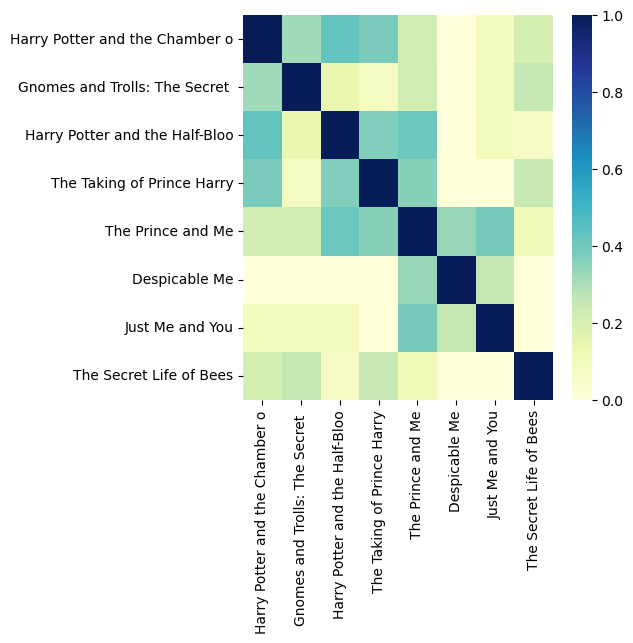

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

#list1= 'Drama Mystery Fantasy Adventure'
#list2= 'Fantasy Adventure  Adventure  Epic  Fantasy  Drama  Action Sword and sorcery'
#list3= 'Satire Comedy Family'
#list4= 'Musical Drama Comedy'
#list5= 'Romantic Comedy Romance Comedy'
#list6= 'Comedy'

list1= 'Harry Potter and the Chamber of Secrets'
list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
headlines = [list1,list2,list3,list4,list5,list6,list7,list8]

labels = [headline[:30] for headline in headlines] 
def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
X = vectorizer.fit_transform(headlines)
#print(vectorizer.get_feature_names())
list_vectors = X.toarray()
print("Example cosine similarities between 8 movie titles: \n",cosine_similarity(list_vectors))
create_heatmap(cosine_similarity(list_vectors))

#### GloVe algorithm
**Definition**
The `GloVe` algorithm is an opensource standford algorithm that associates similarity between words by obtaining vectors representations for words and by mapping them into a meaningful space.

**Implementation** 
We can apply soft cosine similarity computation to study similarity between texts. The matrix S from the soft cosine definition can be calculated with the library `GenSim` and using the `GloVe` algorithm. We would obtain a dataset containing a vector for all the words in our corpus and we could compute the matrix S associating a similarity matrix to all of these words. Then with the soft cosine similarity we could analyse the similarity between the documents in our corpus. 

**Movie Attribute similarity that can be studied**
- Title

In [59]:
from re import sub
from gensim.utils import simple_preprocess
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

query= 'Harry Potter and the Chamber of Secrets'

list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
documents = [list2,list3,list4,list5,list6,list7,list8]
stopwords = ['the', 'and', 'are', 'a']

# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

# Preprocess the documents, including the query string
corpus = [preprocess(document) for document in documents]
query = preprocess(query)

In [61]:
# Load the model: this is a big file, can take a while to download and open
glove = api.load("glove-wiki-gigaword-50")    
similarity_index = WordEmbeddingSimilarityIndex(glove)

# Build the term dictionary, TF-idf model
dictionary = Dictionary(corpus+[query])
tfidf = TfidfModel(dictionary=dictionary)

# Create the term similarity matrix.  
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)

100%|██████████| 18/18 [00:00<00:00, 97.30it/s]


In [62]:
# Compute Soft Cosine Measure between the query and the documents.
# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
query_tf = tfidf[dictionary.doc2bow(query)]

index = SoftCosineSimilarity(tfidf[[dictionary.doc2bow(document) for document in corpus]],similarity_matrix)

doc_similarity_scores = index[query_tf]

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(doc_similarity_scores)[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(f'{idx} \t {doc_similarity_scores[idx]:0.3f} \t {documents[idx]}')

Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:
1 	 0.622 	 Harry Potter and the Half-Blood Prince
2 	 0.580 	 The Taking of Prince Harry
0 	 0.550 	 Gnomes and Trolls: The Secret Chamber
6 	 0.370 	 The Secret Life of Bees
5 	 0.000 	 Just Me and You
4 	 0.000 	 Despicable Me
3 	 0.000 	 The Prince and Me


/Users/camilleguillaume/opt/anaconda3/envs/ada/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
/Users/camilleguillaume/opt/anaconda3/envs/ada/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)


### 3. Topic extraction method
To compare plots, we will use a topic extraction algorithm. There are a lot that exist, but we will concentrate on three possible: LDA, Doc2Vec and BERTopic.

#### Preprocessing method on a document corpus before topic extraction

Here is a preprocessing approach that can be implemented before using a topic extraction analysis
1. Removing the stop words from the documents which are the most common words occuring in texts that give no additional concept. It can be done with `Java` using `MySQL`.
2. Removing the numbers appart from years, the non-asci characters, and most common occuring names (ex: James, Robert, John)
3. Handle pural and singular form of the same word by lemmatizing.
4. We can filter the words using tf-idf. We can compute the tf-idf for each word of each plot and keep the words with highest tf-idf score. The threshold for a word to be kept has to be defined.

#### LDA: Latent Dirichlet Allocation

<div>
<img src="images/LDA_example.png" width="800"/>
</div>

**Definition**

LDA is an algorithm that can be used for topic extraction in texts. It is an unsupervised machine-learning model that takes documents as input and finds topics as output. A topic is represented as a weighted list of words. The model also says in what percentage each document talks about each topic. 

**Implementation**

LDA can be implemented using the `GenSim` library. When using LDA to analyse topics in a corpus, it needs some preprocessing steps before applying the algorithm to make it more efficient. We detailed one preprocessing approach above.


After this processing we can apply LDA on our database by tuning some parameters:
<br>
$K$: the number of topics we look for
<br>
$\alpha$: K-dimension vector of positive reals that represent the prior weights of topic K in a document which affects the document-topic distribution. 
<br>
$\eta$: V-dimension vector of positive reals that represents the prior weights of each words in topics which affects the topic-word distribution

If we chose a symetric LDA, the weights $\alpha$ would be the same for all topics and the weights $\eta$ would be the same for all words in a topic. The smaller the $\alpha$ the fewer topics per document, the fewer the $\eta$ the fewer words per topic.

#### Doc2Vec topic extraction
**Definition**

Doc2Vec is an unsupervised algorithm that learns fixed-length feature vectors for paragraphs/documents/texts. Then we can compare these vectors to assess the similarity between documents. Doc2vec allows to generate a semantic space which is a spatial space where distance among vectors are indicator of semantic similarity. This semantic space consisting of word and document vectors is a continuous representation of topics, unlike LDA where topics are sampled from a discrete space. It means that the dense areas having high concentration of document can be thought of having similar topics and can be best represented by nearby embedded words.

**Implementation**

It can be implemented using the `GenSim` library with the class `Doc2Vec` that extends the class `Word2Vec`. 

#### BERTopic

<div>
<img src="images/BERTopic.png" width="600"/>
</div>

**Definition**
BERTopic is a guided semi-supervised topic modeling algorithm. Contrary to LDA, it uses embeddings (thus semi-supervised) and class-based tf-idf (ctf-idf) to find easily interpretable topics and makes it more stable to small variations. It works in three stages:

- Embed the documents
- Cluster the documents
- Create a list of topics and their representation

With this algorithm it is possible to find a list of topics and also give the probability of each topic in each document.

**Implementation**

BERTopic can be implemented using the python `BerTopic` library. As with LDA, we can preprocess the documents (plots in our case) before giving it to the BERTopic for better results.

Each stage of the BERTopic can be parameterized to get better results:
<br>
$Embedding$: by default it uses the `paraphrase-MiniLM-L6-v2` sentence transformers, but we can use any other embedding technique.
<br>
$Clustering$: by default it uses HDBSCAN (hierarchical DBSCAN) to cluster the documents, but to apply this efficiently UMAP is used to reduce the dimensionality of the embeddings. It is possible to change the dimension reduction algorithm and the clustering algorithm, for example we could import K-means form `sklearn.cluster` and use that.
<br>
$Topic$ $representation$: by default it uses class-based tf-idf, meaning it adjusts the tf-idf inside each class (cluster) in relation with the frequency of a word inside the class. Here again it can be tuned for example to try to show different representatives of a cluster. This can be useful to avoid having "bycycle", "cycling" and "bike" as the representatives of a cluster, where only one of them would have been enough.

#### Computation of similarity from topic extraction

Regardless of the method of analysis of the plot, we can have a vector representation at the end:
- Doc2Vec gives a vector directly
- LDA gives the freqency of each topic per document. We can build a vector for each document where each element represents a topic, and it will be proportional to the frequency of the topic.
- BERTopic gives a probability of each topic per document. Similarly to LDA we can build a vector where each element is a topic and fill it with the corresponding probability.

We can then compare these vectors using the cosine similarity for example.

### 4. Tuning the weights using sequels

How to tell if our similarity function between two movies is working well? First of all, we can't say it for sure, since it is a subjective question. However usually we can still agree on these points:

* Movies that are part of a sequel should have a high similarity
* Movies with completely different genres should have a low similarity (for exmaple one is a "Adventure/Aciton" movie and the other a "Romantic Comedy")

Hence we can build two datasets, one of pairs of movies we expect to have a high similarity and the other of pairs of movies we expect to have low similarity. We can then use these datasets to assess if our similarity function is giving the "right" values.

**Movies from sequels**

Before creating pairs of movies that are similar we should group movies by sequels. Unfortunately, we don't have this data directly accessible in our dataset, but by using the name.clusters.txt file we can have characters that are re-used. It doesn't necesseraly mean that the movie is a sequel (for example with Sherlock Holmes it can be the another representation of him playing), but we still expect these movies to be similar.

First, using the `df_char` dataframe from character.metadata.tsv and the `freeID_char_map` given for each character, we find the unique `WikiID` movie in which the character is played.

In [41]:
df_char_names["WikiID"] = [ df_char[df_char['freeID_char_map'] == x]["WikiID"].item() for x in df_char_names["freeID_char_map"]]

Then we group all characters together, so for each character we have a list of movies in which he played (represented by their WikiID).

In [42]:
df_char_grouped = df_char_names.groupby("char_name")["WikiID"].apply(set).to_frame()
df_char_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 'Baby' Louise to Zack Martin
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   WikiID  970 non-null    object
dtypes: object(1)
memory usage: 15.2+ KB


We could stop here, but right now we still have repetitions: for example Harry Potter and Hermione Granger will appear in the same movies, it would be good to group them together to have a list of separate sequels. However we will have a problem: what to do if only some actors repeat? For example if we take "The Lord of the Rings" and "The Hobbit", Gandalf will appear in both, Aragorn only in "The Lord of the Rings" and Thorin Oakenshield only in "The Hobbit". In our case, we will assume if some characters repeat in these sequels and others don't, it's still highly likely very similar movies, so we will group them all together.

In other words, we group the movies together until we have disjoint movie sets.

Because the list of grouped characters isn't that big (970 rows), we can work with python lists instead of the panda dataframe. We create a list of movie sets (each element of the list comes from one character):

In [43]:
starting_list = []
# Iterate over each row
for index, rows in df_char_grouped.iterrows():
    # append the list to the final list
    starting_list.append(rows["WikiID"])

Then we join the movies sets from different characters if they both appear in at least one same movie. To do it, we create an empty list, and then iteratively check if we should append a new set (if it has no intersection with the previously added) or make a union with an already existing set (if there is an intersection). To assure that the sets are completely disjoint we run this merging algorithm until the starting "individual" list has the same lenght as the "joined" list.

In [44]:
joined_characters = []
same = False

while not(same):    
    for i in starting_list:
        joined = False
        for j in range(len(joined_characters)):
            if joined_characters[j] & i: #there is an intersection in the sets
                joined_characters[j] = joined_characters[j] | i #the union of both sets
                joined = True
        if joined == False:
            joined_characters.append(i)
    
    if len(starting_list) == len(joined_characters):
        same = True
    else:
        starting_list = joined_characters
        joined_characters = []

print(len(joined_characters))

583


We get 583 different sequels, which will be enough to test for similarities. To actually compute a similarity we will need to choose a sequel, and then choose a pair of movies in this sequel. If a sequel has n movies in it, the number of different pairs we can build is n*(n-1)/2. If we compute this for all sequels, we find that we can have 10929 different possible pairs:

In [45]:
sum_pairs = 0
for i in joined_characters:
    n = len(i)
    sum_pairs = sum_pairs + n*(n-1)/2

print(sum_pairs, "different possible pairs")

10929.0 different possible pairs


**Movies with different genres**

For this milestone we didn't built a dataset of pairs of movies with different genres, because we're confident it won't be a problem to find them. Building a dataset also won't be a problem: you sample a movie randomly, and then sample another one to form a pair. If the second one has an intersection in the genres, you resample it, until you find one with 0 intersection. We won't create all possible pairs because the dataset will be too large.

**Conclusion**

With this two datasets we will be able to test our similarity function, and possibly adjust its values to have a high similarity in sequels and low similarity in movies from completely different genres. We will also need to be careful to not base the tuning completely on this as by the construction of the datasets it will give a high importance to similar characters and genres.

---
## Visualization method

We want to be able to visualize our graph. But how do you represent a graph? You could start by placing one node, and then place its neighbours at a distance (or 1/similarity) around him, then place their neighbours and so on. But with that method you can have a problem of not respecting distances with already 3 nodes A, B and C: for example the distance AB = BC = 1 and distance AC = 10. It means we probably won't be able to represent the graph perfectly, but we can still try to do the best possible by plotting nodes with a high similarity close to each other and those with a low similarity far from each other. This is done using Graph Layout Algorithms.

### Gephi

<div>
<img src="images/gephi.jpg" width="600"/>
</div>

**Definition**

Gephi is an "open-source platform for visualizing and manipulating large graphs". Their Graph Layout Algorithm is force based, meaning nodes will repell and attract each other in function of the distance between them, and the visualization is in the equilibrium state.
 

**Implementation**

We found a [github repository](https://github.com/la-rana-kermit/Gephi-python-module) to interface Gephi with Python, which is what we'll try to use to implement. However this repository doesn't seem very active, so if we get some problems we might switch to the Gephi Software directly.


---

## Annexe: Mathematical definitions related to similarity

#### 1.1 Cosine similarity
$$
cosine \: similarity(A,B)=S_c(A,B)=cos(\theta)=\frac{A \cdot B}{\|A\| \|B\|}=\frac{\sum_{i=1}^{n}A_iB_i}{\sqrt{\sum_{i=1}^{n} A_i^2}\sqrt{\sum_{i=1}^{n} B_i^2}}
$$
Where $A,B \in \mathbb{R}^n$, $S_c(A,B) \in [-1,1]$ where -1 means that the two vectors are exactly opposite, and 1 means that they are exactly similar and 0 means that they are orthognonal which shows decorrelation.

#### 1.2 Centered Cosine similarity
$$
centered \: cosine \: similarity(A,B)=\frac{(A-\overline{A}) \cdot (B-\overline{B})}{\|A-\overline{A}\| \|B-\overline{B}\|}
$$
Where A and B have been normalized before by substracting their mean.

#### 1.3 Soft cosine similarity
$$
soft \: cosine \: similarity(A,B)=\frac{\sum_{i,j}^{n}s_{ij}A_iB_j}{\sqrt{\sum_{i,j}^{n} s_{ij}A_iA_j}\sqrt{\sum_{i,j}^{n} s_{ij}B_iB_j}}
$$
where $s_{ij}$=similarity($feature_i$,$feature_j$). For example if $s_{ii}$=1 and $s_{ij}$=0 $\forall i\neq j$ then there is no similarity between features, then the soft cosine similarity is equal to the cosine similarity. In the case where features are words, the matrix $S$ has to define the similarity between words.

#### 1.4 Associated distance with cosine similarity
- **Angular distance**

if $A_i,B_i \in \mathbb{R}$ 
$$
angular \: distance=D_\theta=\frac{arccos(S_c(A,B))}{\pi}=\frac{\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{\theta}{\pi}
$$
if $A_i,B_i \in \mathbb{R}$ and $A_i,B_i\geq 0$
$$
angular \: distance=D_\theta=\frac{2 \cdot \textrm{arccos}(S_c(A,B))}{\pi}=\frac{2\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{2\theta}{\pi}
$$
Where the angular distacne is a formal distance metric, however the arccos computation cost makes it more computationally expensive and slower.

- **Cosine distance**

$$
cosine \: distance=D_c=1-S_c(A,B)
$$
Where the cosine distance is an unformal distance metric (it does not respect the triangle inequality or Schwarz inequality) but it is less computationally expensive.


- **L2-normalized Euclidean distance**

From the L2 distance defined as followed: $ \|x\|_2=\sqrt{\sum x_i^2}=\sqrt{x.x} $ and the euclidean distance defined as followed: 
$ d(A,B)=|A-B|=\sqrt{\sum _{i=1}^{n} (A_i-B_i)^2 } $, we get the L2-normalized Euclidean distance:
$$
L2-normalized \: Euclidean \: distance=\sqrt{\sum _{i=1}^{n} (A_i'-B_i')^2} \quad \textrm{where} \quad A'=\frac{A}{\|A\|_2}
$$

The cosine similarity and associated distances reflects relative rather than absolute comparison of vectors. For example vectors $A$ and $\alpha A$ where $\alpha \in \mathbb{R}$ are maximally similar. Therefore this similarity is appropriate for data where frequency is more important than absolute value. For text comparison it can be very useful, we could compare the frequency of terms in a document.  

#### 1.5 Jaccard similarity coefficient

$$
J(A,B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$
where $J(A,B) \in [0,1]$.
It measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets.  

#### 1.6 Associated distance with Jaccard similarity
$$
d_J(A,B)=1-J(A,B)=\frac{|A\cup B|-|A\cap B|}{|A\cup B|}
$$
The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union.